# Loading data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/X.npy X.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/y.npy y.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/vars.pkl vars.pkl
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/means.npy means.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/stds.npy stds.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/euclidean-umap.npy euclidean-umap.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/cosine-umap.npy cosine-umap.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/seas_mask.npy seas_mask.npy
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/polar_bear.jpg polar_bear.jpg

# drive.flush_and_unmount()

Mounted at /content/drive
cp: cannot stat 'drive/MyDrive/Andrew Arctic ice research/Data/euclidean-umap.npy': No such file or directory
cp: cannot stat 'drive/MyDrive/Andrew Arctic ice research/Data/cosine-umap.npy': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
import pickle

# shape: (time, x, y, [variables])
X = np.load('X.npy')
y = np.load('y.npy')

with open('vars.pkl', 'rb') as f:
  variable_list = pickle.load(f)

means = np.load('means.npy')
stds = np.load('stds.npy')

# TODO add back when UMAP data is ready
# euclidean_umap = np.load('euclidean-umap.npy')
# cosine_umap = np.load('cosine-umap.npy')
# umap = np.concatenate((euclidean_umap, cosine_umap), axis=-1)

# mask for the 9 Arctic seas, so that only values within these are counted when creating metrics.
# this is of the shape (x, y, 1). the final dimension may be a bit annoying
seas_mask = np.load('seas_mask.npy') * 1.0

print(f"X shape {X.shape} mask {100 * np.sum(seas_mask) / np.size(seas_mask):.2f}%")
print(f"y shape {y.shape} mean {np.mean(y):.2f} std {np.std(y):.2f}")
print(pd.DataFrame(data={"var": variable_list, "mean": means, "std": stds}))

X shape (420, 432, 432, 21) mask 19.34%
y shape (420, 432, 432) mean 0.08 std 0.26
              var          mean           std
0   concentration  8.684072e+00  2.639505e+01
1          extent  1.020174e-01  3.026712e-01
2            land  4.760749e-01  4.994273e-01
3             msl  1.014460e+05  6.915458e+02
4        q_500hPa  6.701027e-04  4.479804e-04
5            slhf -4.264003e+06  4.476535e+06
6              sp  9.802751e+04  5.950361e+03
7            sshf -1.446586e+06  2.291577e+06
8             ssr  9.751797e+06  6.839990e+06
9            ssrd  1.219727e+07  7.683276e+06
10            sst  2.786159e+02  8.332293e+00
11            t2m  2.775803e+02  1.458608e+01
12       t_500hPa  2.507808e+02  9.444659e+00
13             tp  2.208699e-03  2.000683e-03
14            u10  7.104835e-01  2.356681e+00
15        u_10hPa  6.289836e+00  1.803740e+01
16            v10 -9.105964e-02  1.911085e+00
17       z_250hPa  1.007734e+05  3.761266e+03
18       z_500hPa  5.411693e+04  2.228943e+

In [ ]:
# get the correct dataset for a set of variables
def get_X_with_variables(variables=variable_list):
  return X[:, :, :, [v in variables for v in variable_list]]

# to do: probably add an end of the train dataset as well
# maybe not here though
def train_val_test(Xs: tuple[np.ndarray, ...],
                   y: np.ndarray,
                   ) -> tuple[tuple[np.ndarray, ...], np.ndarray, tuple[np.ndarray, ...], np.ndarray, tuple[np.ndarray, ...], np.ndarray]:
  # maybe just set validation and testing to be 4 years
  total_size = len(y)
  assert all(len(X) == total_size for X in Xs)
  val_and_test_size = total_size // 4
  test_size = total_size // 8
  val_start = total_size - val_and_test_size
  test_start = total_size - test_size

  # there's probably a better way to do this...
  Xs_train = tuple(X[:val_start] for X in Xs)
  y_train = y[:val_start]
  Xs_val = tuple(X[val_start:test_start] for X in Xs)
  y_val = y[val_start:test_start]
  Xs_test = tuple(X[test_start:] for X in Xs)
  y_test = y[test_start:]

  return Xs_train, y_train, Xs_val, y_val, Xs_test, y_test

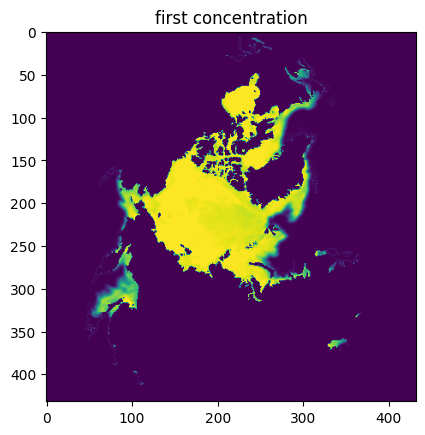

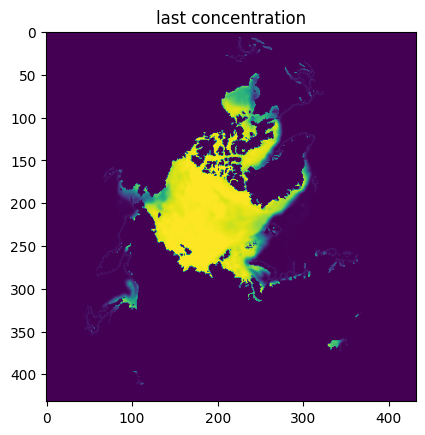

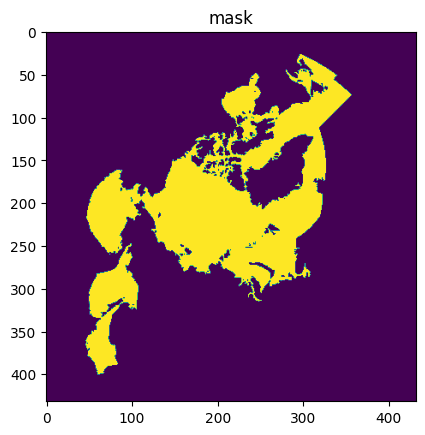

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(y[0])
plt.title("first concentration")
plt.show()
plt.imshow(y[-1])
plt.title("last concentration")
plt.show()
plt.imshow(seas_mask)
plt.title("mask")
plt.show()

# Data augmentation

## DWT

In [ ]:
import numpy as np
import pywt

# Filter bank for the 3-band 2-regular wavelet
wv32 = (
  ( 0.33838609728386,  0.53083618701374,  0.72328627674361,  0.23896417190576,  0.04651408217589, -0.14593600755399),
  (-0.11737701613483,  0.54433105395181, -0.01870574735313, -0.69911956479289, -0.13608276348796,  0.42695403781698),
  ( 0.40363686892892, -0.62853936105471,  0.46060475252131, -0.40363686892892, -0.07856742013185,  0.24650202866523)
)

# Filter bank for the 4-band 2-regular wavelet
wv42 = (
  (-0.067371764,  0.094195111,  0.40580489 ,  0.567371764,  0.567371764,  0.40580489 ,  0.094195111, -0.067371764),
  (-0.094195111,  0.067371764,  0.567371764,  0.40580489,  -0.40580489 , -0.567371764, -0.067371764,  0.094195111),
  (-0.094195111, -0.067371764,  0.567371764, -0.40580489,  -0.40580489 ,  0.567371764, -0.067371764, -0.094195111),
  (-0.067371764, -0.094195111,  0.40580489 , -0.567371764,  0.567371764, -0.40580489 ,  0.094195111,  0.067371764)
)

# Filter bank for the 4-band 4-regular wavelet
wv44 = (
  ( 0.0857130200,  0.1931394393,  0.3491805097,  0.5616494215,  0.4955029828,  0.4145647737,  0.2190308939, -0.1145361261,
   -0.0952930728, -0.1306948909, -0.0827496793,  0.0719795354,  0.0140770701,  0.0229906779,  0.0145382757, -0.0190928308),
  (-0.1045086525,  0.1183282069, -0.1011065044, -0.0115563891,  0.6005913823, -0.2550401616, -0.4264277361, -0.0827398180,
    0.0722022649,  0.2684936992,  0.1691549718, -0.4437039320,  0.0849964877,  0.1388163056,  0.0877812188, -0.1152813433),
  ( 0.2560950163, -0.2048089157, -0.2503433230, -0.2484277272,  0.4477496752,  0.0010274000, -0.0621881917,  0.5562313118,
   -0.2245618041, -0.3300536827, -0.2088643503,  0.2202951830,  0.0207171125,  0.0338351983,  0.0213958651, -0.0280987676),
  ( 0.1839986022, -0.6622893130,  0.6880085746, -0.1379502447,  0.0446493766, -0.0823301969, -0.0923899104, -0.0233349758,
    0.0290655661,  0.0702950474,  0.0443561794, -0.0918374833,  0.0128845052,  0.0210429802,  0.0133066389, -0.0174753464)
)

WAVELETS = dict(
    # none=((1,),),
    wv32=wv32,
    wv42=wv42,
    wv44=wv44,
)
for i in range(1, 6):
  dbi = pywt.Wavelet(f'db{i}').filter_bank[2:4]
  WAVELETS[f'db{i}'] = dbi

# to do: maybe use numpy more, e.g. np.shape() for the number of bands and filter bank length
def dwt_matrix(filter_banks, rows_per_filter_bank):
  filter_banks = np.array(filter_banks)

  # assertions that may or may not be needed
  num_bands, filter_bank_length = filter_banks.shape
  num_bands = len(filter_banks)
  assert num_bands > 0
  assert filter_bank_length % num_bands == 0 # this is true because an M-band L-regular DWT matrix has M filters with length ML
  # Mk x Mk matrix
  matrix_size = num_bands * rows_per_filter_bank
  assert matrix_size >= filter_bank_length

  shift = num_bands
  res = np.zeros((matrix_size, matrix_size))
  row = 0
  for filter_bank in filter_banks:
    current_offset = 0
    for _ in range(rows_per_filter_bank):
      for (i, value) in enumerate(filter_bank):
        res[row][(current_offset + i) % matrix_size] = value
      current_offset += shift
      row += 1
  return res

# takes in a 4D np array of shape (time, x, y, n_var) and outputs a 4D one of same shape
# the time dimension is basically ignored and is for vectorization
# works only for square images
def dwt(wavelet, signal):
  n_band = len(wavelet)
  n_time, x, y, n_var = signal.shape
  assert x == y
  assert x % n_band == 0
  k = x // n_band
  matrix = dwt_matrix(wavelet, k).astype(np.float32)
  values = np.matmul(np.matmul(matrix, signal.astype(np.float64), axes=[(-2, -1), (1, 2), (1, 2)]), matrix.T, axes=[(1, 2), (-2, -1), (1, 2)])
  # values has shape (time, x, y, n_var) where x = y, x' = y' and x = n_band * x'
  # the reshape puts it into shape (time, wx, x', wy, y', n_var), then transpose to (time, wx, wy, x', y', var), then merge wx and wy with band
  # does the final reshape do what I want it to do?
  return values

# # takes in a 4D np array of shape (time, x, y, n_var) and outputs a 6D one of shape (time, wx, wy, x', y', n_var)
# # wx = wy = n_band, x' = y' = rows_per_filter_bank
# # the time dimension is basically ignored and is for vectorization
# # works only for square images
# def reshape_dwt(wavelet, signal):
#   n_band = len(wavelet)
#   n_time, x, y, n_var = signal.shape
#   assert x == y
#   assert x % n_band == 0
#   k = x // n_band
#   return signal.reshape((n_time, n_band, k, n_band, k, n_var)).transpose(0, 1, 3, 2, 4, 5)

def a_d_components(wavelet, signal):
  '''
  Project tensor after wavelet transformation back to original domain.
  :param wavelet: wavelet filterbank of shape (n_band, n_band * n_regular)
  :param signal: 4D tensor of shape (time, x, y, n_var)
  :returns:
  '''
  n_band = len(wavelet)
  n_time, x, y, n_var = signal.shape
  assert x == y
  k = x // n_band
  matrix = dwt_matrix(wavelet, k).astype(np.float32)
  block_signal_list = []
  for i in range(n_band):
    for j in range(n_band):
      block_mask = np.zeros((x, x))
      block_mask[i * k: (i + 1) * k, j * k: (j + 1) * k] = 1.0
      block_signal = np.einsum('txyv,xy->txyv', signal, block_mask)
      block_signal_list.append(block_signal)
  # block tensor has shape (t, x, y, n_band^2 * n_var)
  block_signal_tensor = np.concatenate(block_signal_list, axis=3)
  del block_signal_list

  # Slightly faster for tranditional matmul, but use einsum for its implicity
  # projected = np.matmul(np.matmul(matrix.T, block_signal_tensor, axes=[(0, 1), (1, 2), (1, 2)]), matrix, axes=[(1, 2), (0, 1), (1, 2)])
  projected = np.einsum('yx,txzn,zw->tywn', matrix.T, block_signal_tensor, matrix, optimize=True)
  return projected

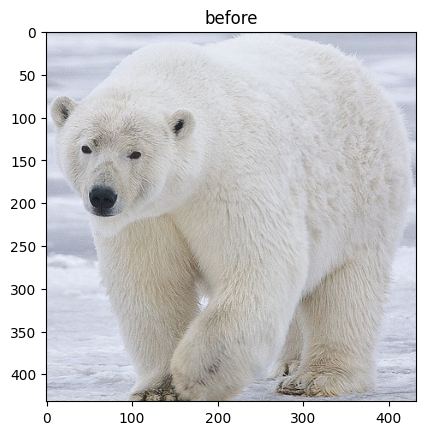

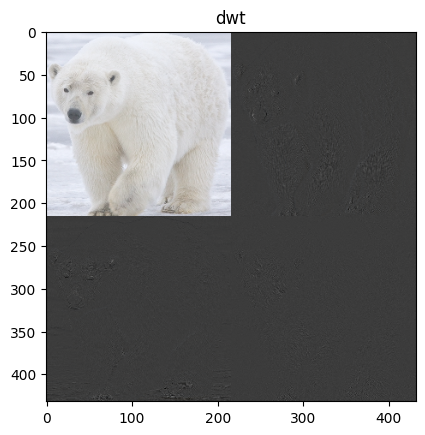

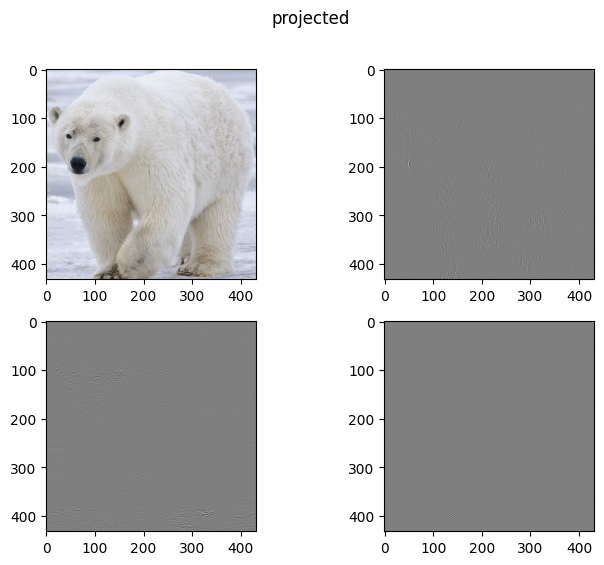

In [ ]:
# Test DWT
import matplotlib.pyplot as plt

def to_im(signal: np.ndarray):
  return (signal.squeeze() - np.min(signal)) / (np.max(signal) - np.min(signal))

im = plt.imread("polar_bear.jpg", format='jpeg')
x_size = y_size = 432
x_start = (im.shape[0] - x_size) // 2
y_start = (im.shape[1] - y_size) // 2
im = im[x_start: x_start + x_size, y_start: y_start + y_size, :]
wavelet = WAVELETS["db1"]

plt.imshow(im)
plt.title("before")
plt.show()

signal = im[np.newaxis, :]
dwt_signal = dwt(wavelet, signal)
plt.imshow(to_im(dwt_signal))
plt.title("dwt")
plt.show()

projected_signal = a_d_components(wavelet, dwt_signal)
n_band = len(wavelet)
n_var = dwt_signal.shape[3]
fig, axes = plt.subplots(n_band, n_band, figsize=(8, 6))
for i in range(n_band):
  for j in range(n_band):
    channel = (i * n_band + j) * n_var
    axes[i, j].imshow(to_im(projected_signal[:, :, :, channel: channel + n_var]))
fig.suptitle("projected")
plt.show()

In [ ]:
from typing import List

def add_wavelet_data(
    x: np.ndarray,
    variables: List[str],
    wavelets: List[np.ndarray],
    skip: List[str]=["cos_month", "sin_month", "land"]
):
  """
  :PARAM x: Input ndarray of shape (time, x, y, var)
  :PARAM variables: variables included in X
  :PARAM wavelets: wavelet transformations to apply
  :PARAM skip: variables to skip
  :RETURNS: Agumented ndarray with additional variables for wavelet transformation
  """
  assert len(x.shape) == 4
  assert x.shape[1] == x.shape[2]
  assert len(variables) == x.shape[3]
  var_indices = [i for i, var in enumerate(variables) if i not in skip]
  signal = x[:, :, :, var_indices]

  augmented_x = np.copy(x)
  for wavelet in wavelets:
    dwt_signal = dwt(wavelet=wavelet, signal=signal)
    projected_signal = a_d_components(wavelet=wavelet, signal=dwt_signal)
    augmented_x = np.concatenate([augmented_x, projected_signal], axis=3)
  return augmented_x

## UMAP

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=74d1827810e6b70d5449dc95ed9e884d2049a027dde6e17a2df20e33ead5580d
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=bd53309f5fd1e81ac6bfd4d440a3cd532b06a8afe80e2505c99e077488dd1117
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
from datetime import datetime
import os
import numpy as np
import umap.umap_ as umap

def add_umap_data(
    train_x: np.ndarray,
    transform_x: np.ndarray,
    n_component = 72,
    n_neighbor_list = [2, 5, 10, 20, 50],
    min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99],
    metric_list = ["euclidean", "chebyshev", "minkowski", "correlation"],
    cache: bool = False,
):
  """
  # Transform time series of 3D array of (x, y, var) to different flavors of
  # 81 components umap embedding. Tile those matrices to shape (x, y, 1) and concat
  # to input matrix.
  :PARAM train_x: Input training data of shape (time, x, y, var)
  :PARAM transform_x: Data to be transformed.
  """
  assert len(train_x.shape) == 4
  assert len(transform_x.shape) == 4
  assert train_x.shape[1:] == transform_x.shape[1:]
  n_time_train, n_x, n_y, n_var = train_x.shape
  n_time_transform = transform_x.shape[0]
  assert n_x == n_y
  assert n_x == 432

  cache_file = "umap.cache.npy"
  if cache and os.path.exists(cache_file):
    print(f"Load cached umap embedding from {cache_file}")
    embedding_var = np.load(cache_file)
    return np.concatenate([transform_x, embedding_var.reshape((n_time_transform, n_x, n_y, 1))], axis=3)

  train_x = train_x.reshape((n_time_train, -1))
  transform_x = transform_x.reshape((n_time_transform, -1))
  embedding_var = np.zeros((n_time_transform, n_x * n_y))
  idx = 0
  for metric in metric_list:
    for n_neighbor in n_neighbor_list:
      for min_dist in min_dist_list:
        print(f"{datetime.now()} training UMAP model n_neighbors={n_neighbor} min_dist={min_dist} metric={metric}")
        model = umap.UMAP(
            n_components=n_component,
            n_neighbors=n_neighbor,
            min_dist=min_dist,
            metric=metric,
            random_state=42
        ).fit(train_x)
        embedding = model.transform(transform_x)
        embedding_var[:, idx: idx + n_component] = embedding
        idx += n_component
  # Fill rest of matrix with same data
  while idx < embedding_var.shape[1]:
    idx_end = min(embedding_var.shape[1], 2*idx)
    embedding_var[:, idx:idx_end] = embedding_var[:, 0: idx_end - idx]
    idx = idx_end
  if cache:
    np.save(cache_file, embedding_var)
    print(f"Cached umap embedding at {cache_file}")
  return np.stack([transform_x, embedding_var], axis=2).reshape((n_time_transform, n_x, n_y, -1))

2023-10-07 14:25:21.402526 training UMAP model n_neighbors=2 min_dist=0.0 metric=euclidean


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2023-10-07 14:25:38.401506 training UMAP model n_neighbors=2 min_dist=0.99 metric=euclidean


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2023-10-07 14:25:41.382142 training UMAP model n_neighbors=5 min_dist=0.0 metric=euclidean


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2023-10-07 14:25:44.868406 training UMAP model n_neighbors=5 min_dist=0.99 metric=euclidean


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


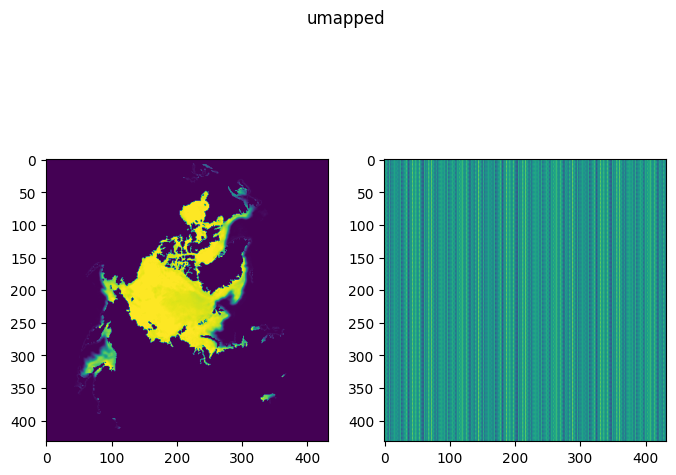

In [ ]:
# Test umap

conc_x = get_X_with_variables(('concentration',))
umapped = add_umap_data(
  train_x=conc_x[0:60,],
  transform_x=conc_x[0:72],
  n_neighbor_list = [2, 5],
  min_dist_list = [0.0, 0.99],
  metric_list = ["euclidean"],
  cache=False,
)

fig, axes = plt.subplots(ncols=2, figsize=(8, 6))
axes[0].imshow(to_im(umapped[0, :, :, 0]))
axes[1].imshow(to_im(umapped[0, :, :, 1]))
fig.suptitle("umapped")
plt.show()

## Sequence stuff

In [ ]:
from tensorflow import keras
from typing import Optional, Callable
import random
random.seed(42)

In [ ]:
# for when the output is an image
# allow feeding the model rolling periods without having to produce them ahead of time
# let this take in its own X and y, to prevent overlap
# maybe see keras.utils.timeseries_dataset_from_array?
# e.g. (would need to shift y, though, and I don't know how to do multiple inputs and outputs, or restrict each thing to 64)
# keras.utils.timeseries_dataset_from_array(X, y, sequence_length=12, batch_size=None)
# to do: double-check this code
class RollingImageSequence(keras.utils.Sequence):
  # note that some things that weren't tuples are now tuples, so some other code may need to be changed
  def __init__(self,
               Xs: tuple[np.ndarray, ...], # multiple Xs; note: this should be an iterable of np arrays
               y: np.ndarray, # y might not be needed? but it also might still be nice to keep it around?
               num_prev_timesteps: int = 12, # number of previous timesteps of Xs to give as input
               lead_times: tuple[int, ...] = (1,), # numbers of timesteps ahead to predict y for
               apply_to_Xs: Optional[tuple[Callable[[np.ndarray], np.ndarray], ...]] = None, # what to apply to each sequence of Xs. for example, a DWT on the time dimension would be lambda x: vectorized_a_d_components(wavelet, x)
               concat: bool = False, # True for non-LSTM, False for LSTM
               num_batches: Optional[int] = None,
               batch_size: int = 1,
               shuffle: bool = True,
               ) -> None:
    # tuple of timestep arrays of dimension (time, ..., variables)
    self.Xs = Xs
    # convert Y to (time, x, y, 1) if needed
    self.y = y
    self.total_timesteps = len(self.y)
    assert all(len(X) == self.total_timesteps for X in self.Xs)
    self.num_prev_timesteps = num_prev_timesteps
    self.lead_times = lead_times

    if apply_to_Xs is None:
      apply_to_Xs = tuple(lambda x: x for _ in self.Xs)
    self.apply_to_Xs = apply_to_Xs
    assert len(self.Xs) == len(self.apply_to_Xs)
    self.concat = concat

    self.batch_size = batch_size
    self.num_batches = num_batches

    self.shuffle = shuffle
    self.num_points = self.total_timesteps - self.num_prev_timesteps + 1 - max(self.lead_times)
    assert self.num_points > 0
    if self.shuffle:
      self.shuffle_indices()
    else:
      self.indices = range(self.num_points)

  def __len__(self) -> int:
    if self.num_batches is None:
      # note: if self.num_points isn't a multiple of batch_size then this ignores the remaining bit at the end of less then batch_size elements
      # but maybe don't do so, especially if the batch size is big
      return self.num_points // self.batch_size
    else:
      return self.num_batches

  # note that this doesn't rely on self.indices already being defined
  def shuffle_indices(self) -> None:
    self.indices = random.sample(range(self.num_points), self.num_points)

  def on_epoch_end(self) -> None:
    if self.shuffle:
      self.shuffle_indices()

  def get_indices_of_batch(self, idx: int) -> tuple[int, ...]:
    return self.indices[idx*self.batch_size : (idx+1)*self.batch_size]

  def __getitem__(self, idx: int) -> tuple[tuple[np.ndarray, ...], np.ndarray]:
    # this can definitely be rewritten
    def helper(array: np.ndarray, # of shape (time, x, y, [variables])??
               apply_to_indexed: Callable[[np.ndarray], np.ndarray] = lambda x: x,
               indexing: Callable[[int], int | slice] = lambda i: slice(i, i + self.num_prev_timesteps),
               concat: bool = False,
               ) -> np.ndarray:
      # the first dimension of the array is the batch size
      res = np.array([apply_to_indexed(array[indexing(i)]) for i in self.get_indices_of_batch(idx)])
      if concat:
        # concatenate the second dimension onto the last dimension
        res = np.moveaxis(np.concatenate(np.moveaxis(res, 0, -1), axis=-2), -1, 0)
      return res
    # to do: concatenate these if self.concat is true
    # the different lead times should be different variables, which is why they're on the last axis
    # this expects self.y to be of shape (time, x, y); if it were of shape (time, x, y, variables) instead then np.concatenate would be more appropriate
    y_part = np.stack([helper(self.y, indexing=lambda i: i + self.num_prev_timesteps - 1 + lead_time) for lead_time in self.lead_times], axis=-1)
    return tuple(helper(x, f, concat=self.concat) for x, f in zip(self.Xs, self.apply_to_Xs)), y_part

In [ ]:
# to do: probably add an end of the train dataset as well
# maybe not here though
def train_val_test(Xs: tuple[np.ndarray, ...],
                   y: np.ndarray
                   ) -> tuple[tuple[np.ndarray, ...], np.ndarray, tuple[np.ndarray, ...], np.ndarray, tuple[np.ndarray, ...], np.ndarray]:
  # maybe just set validation and testing to be 4 years
  total_size = len(y)
  assert all(len(X) == total_size for X in Xs)
  val_and_test_size = total_size // 4
  test_size = total_size // 8
  val_start = total_size - val_and_test_size
  test_start = total_size - test_size

  # there's probably a better way to do this...
  Xs_train = tuple(X[:val_start] for X in Xs)
  y_train = y[:val_start]
  Xs_val = tuple(X[val_start:test_start] for X in Xs)
  y_val = y[val_start:test_start]
  Xs_test = tuple(X[test_start:] for X in Xs)
  y_test = y[test_start:]

  return Xs_train, y_train, Xs_val, y_val, Xs_test, y_test

In [ ]:
def get_sequences(Xs, y, train_num_batches=64, val_test_shuffle=False, **seq_kwargs):
  Xs_train, y_train, Xs_val, y_val, Xs_test, y_test = train_val_test(Xs, y)

  train_seq = RollingImageSequence(Xs_train, y_train, num_batches=train_num_batches, **seq_kwargs)
  val_seq = RollingImageSequence(Xs_val, y_val, shuffle=val_test_shuffle, **seq_kwargs)
  test_seq = RollingImageSequence(Xs_test, y_test, shuffle=val_test_shuffle, **seq_kwargs)

  return train_seq, val_seq, test_seq

In [ ]:
def actual(seq: RollingImageSequence) -> np.ndarray:
  return np.array([seq[i][1] for i in range(len(seq))])

# Model

## Model code

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.layers import Input, TimeDistributed, Conv2D, MaxPool2D, Flatten, Dense, LSTM, Conv2DTranspose, Concatenate, UpSampling2D, Reshape, Permute, ConvLSTM2D
from typing import Callable, Optional

In [ ]:
tf.random.set_seed(42)

In [ ]:
# Code in this cell is shared between model and view results. Make sure to keep them consistent!!!

import tensorflow as tf
from tensorflow import keras

# not used right now, but kept in case we might use it
# why is there a minus sign at the start?
def wavelet_activation(x):
  return -x * tf.exp(-x**2)

# ignore land when calculating loss

# note that land is normalized and was originally 0 for no land and 1 for land, so land is positive and non-land is negative
# note that the last dimension of this is 1, so multiplying this with things with greater last dimensions works.
# not needed, since not using this as a mask but instead the seas
#non_land_mask = (get_X_with_variables(('land',))[0] < 0)

def masked_mse(y_true, y_pred):
  y_true_masked = tf.math.multiply(y_true, seas_mask)
  y_pred_masked = tf.math.multiply(y_pred, seas_mask)
  # scale the result to act like you only count the values in seas_mask
  # the division by the last element of the shape is since y_true may have multiple variables while seas_mask may have less
  return keras.losses.mean_squared_error(y_true_masked, y_pred_masked) * tf.cast(tf.size(y_true) / tf.shape(y_true)[-1], tf.float32) / tf.reduce_sum(seas_mask.astype(np.float32))

# binary crossentropy
def masked_bce(y_true, y_pred):
  y_true_masked = tf.math.multiply(y_true, seas_mask)
  y_pred_masked = tf.math.multiply(y_pred, seas_mask)
  # take the mean crossentropy over the mask
  # note that values predicted right have zero loss so you can ignore values outside the mask
  return tf.math.reduce_sum(keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)) / tf.reduce_sum(seas_mask.astype(np.float32))

In [ ]:
# for ConvLSTM testing
# possibility: make them all ConvLSTM layers, with return_sequences=True except for the last one
# (note: that takes too long)

# IceNet-like
# note that if you have umap then you must also have lstm
# note: if doing regression, do logistic transformation to make sure outputs are between 0 and 100
# also re-get SIC data
def make_model(input_shape: tuple[int, ...] = (12, 432, 432, 21), # should be like (432, 432, 21*12) for non-lstm, (12, 432, 432, 21) for lstm
                                                                  # should there be a None in front? (it seems to automatically be placed in front)
               #num_previous_months: int = 12,
               #pool_amts: tuple[int, ...],
               #n_channels: tuple[int, ...] = (8, 16, 16, 16),
               #learning_rate: float = 1e-3,
               num_output_months: int = 1,
               use_lstm: bool = False,
               umap: bool = False,
               umap_shape: Optional[tuple[int, ...]] = (12, 144),
               conv_transpose: bool = True,
               cnn_activation: str | Callable[[float], float] = 'relu',
               lstm_activation: str | Callable[[float], float] = 'tanh',
               filters_multiplier: int = 8,
               kernel_size: tuple[int, int] = (3, 3),
               classification: bool = False,
               ) -> keras.Model:

  ConvLayer = lambda filters: Conv2D(filters, kernel_size, padding='same', activation=cnn_activation)
  # for some of the lambda stuff, if you don't do it then it treats instances of Downsampling layer (no longer here) as the same layer
  # amount is the amount to upsample by
  UpsamplingLayer = lambda amount, filters: (Conv2DTranspose(filters, (amount, amount), strides=(amount, amount), padding='same', activation=cnn_activation) if conv_transpose else UpSampling2D((amount, amount)))
  t = (lambda l: TimeDistributed(l)) if use_lstm else lambda l: l

  inputs = []
  input_layer = Input(shape=input_shape)
  inputs.append(input_layer)
  # note: UMAP actually isn't added like this
  if umap:
    umap_input = Input(shape=umap_shape)
    inputs.append(umap_input)

  # to do: maybe make it thicker (i.e. more filters)

  conv1 = t(ConvLayer(1*filters_multiplier))(input_layer)
  pool1 = t(MaxPool2D((4, 4)))(conv1)

  conv2 = t(ConvLayer(2*filters_multiplier))(pool1)
  pool2 = t(MaxPool2D((4, 4)))(conv2)

  if use_lstm:
    conv3 = ConvLSTM2D(4*filters_multiplier, kernel_size, padding='same')(pool2)
  else:
    conv3 = ConvLayer(4*filters_multiplier)(pool2)

  upsamp1 = UpsamplingLayer(4, 2*filters_multiplier)(conv3)

  # note: how does this concatenation work when there are TimeDistributed layers? (should it just put those layers together on the time axis as separate features?)
  if use_lstm:
    # do only the most recent month if use_lstm
    #slice1 = conv2[:, -1, :, :, :]
    # actually, do all months
    permute1 = Permute((2, 3, 1, 4))(conv2)
    slice1 = Reshape((permute1.shape[1], permute1.shape[2], -1))(permute1)
  else:
    slice1 = conv2
  concat1 = Concatenate()((slice1, upsamp1))
  conv4 = ConvLayer(2*filters_multiplier)(concat1)
  upsamp2 = UpsamplingLayer(4, 1*filters_multiplier)(conv4)

  if use_lstm:
    #slice2 = conv1[:, -1, :, :, :]
    permute2 = Permute((2, 3, 1, 4))(conv1)
    slice2 = Reshape((permute2.shape[1], permute2.shape[2], -1))(permute2)
  else:
    slice2 = conv1
  concat2 = Concatenate()((slice2, upsamp2))
  conv5 = ConvLayer(1*filters_multiplier)(concat2)

  # no matter whether the problem is classification or regression, the output value should be between 0 and 1, so a sigmoid activation function is chosen.
  output_layer = layers.Conv2D(num_output_months, (1, 1), padding='same', activation='sigmoid')(conv5)

  model = keras.Model(inputs=inputs, outputs=output_layer)

  model.compile(optimizer=keras.optimizers.Adam(),
                loss=masked_mse if not classification else masked_bce)

  return model

Note: keep the number of params low (maybe less than 500k)

In [ ]:
checkpoint_filepath = 'checkpoint.ckpt'

def fit(model, train_seq, val_seq, epochs=36, earlystopping=True, do_multiprocessing=False):
  callbacks = []
  if earlystopping:
    # get the best weights without restore_best_weights
    # see https://medium.com/@doleron/never-use-restore-best-weights-true-with-earlystopping-754ba5f9b0c6
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=4,
                                               restore_best_weights=False)
    callbacks.append(early_stop)

    checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                 monitor='val_loss',
                                                 save_best_only=True)
    callbacks.append(checkpoint)
  if not do_multiprocessing:
    history = model.fit(train_seq, epochs=epochs, callbacks=callbacks, validation_data=val_seq)
  else:
    history = model.fit(train_seq, epochs=epochs, callbacks=callbacks, validation_data=val_seq, workers=2, use_multiprocessing=True)
  if earlystopping:
    model.load_weights(checkpoint_filepath)
  return history

## Model diagrams etc. (maybe move)

In [ ]:
model = make_model(use_lstm=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 432, 432, 21)]   0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 12, 432, 432, 8)      1520      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 12, 108, 108, 8)      0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

In [ ]:
make_model(input_shape=X.shape[1:]).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 432, 432, 21)]       0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 432, 432, 8)          1520      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 108, 108, 8)          0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 108, 108, 16)         1168      ['max_pooling2d_2[0][0]'

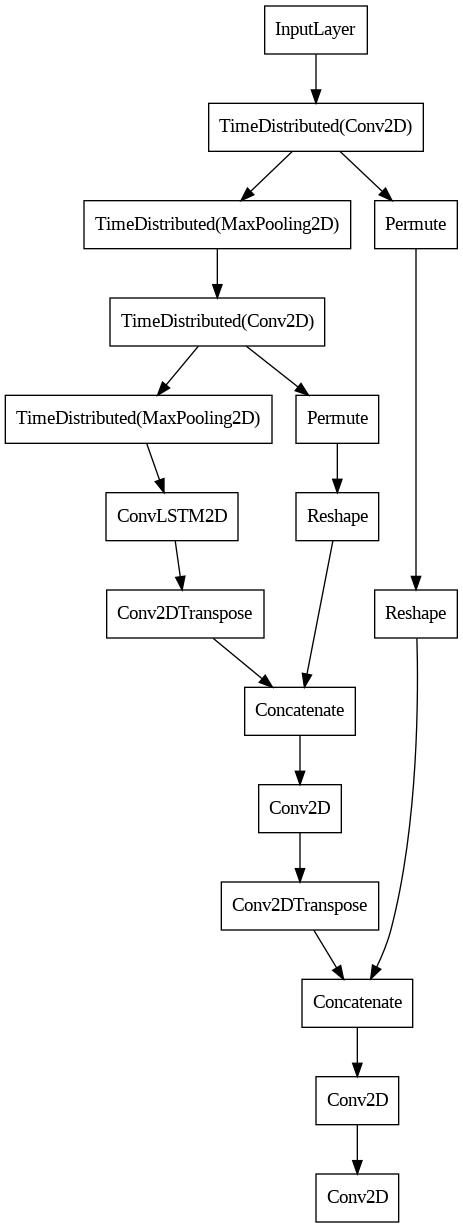

In [ ]:
keras.utils.plot_model(model, show_layer_names=False)

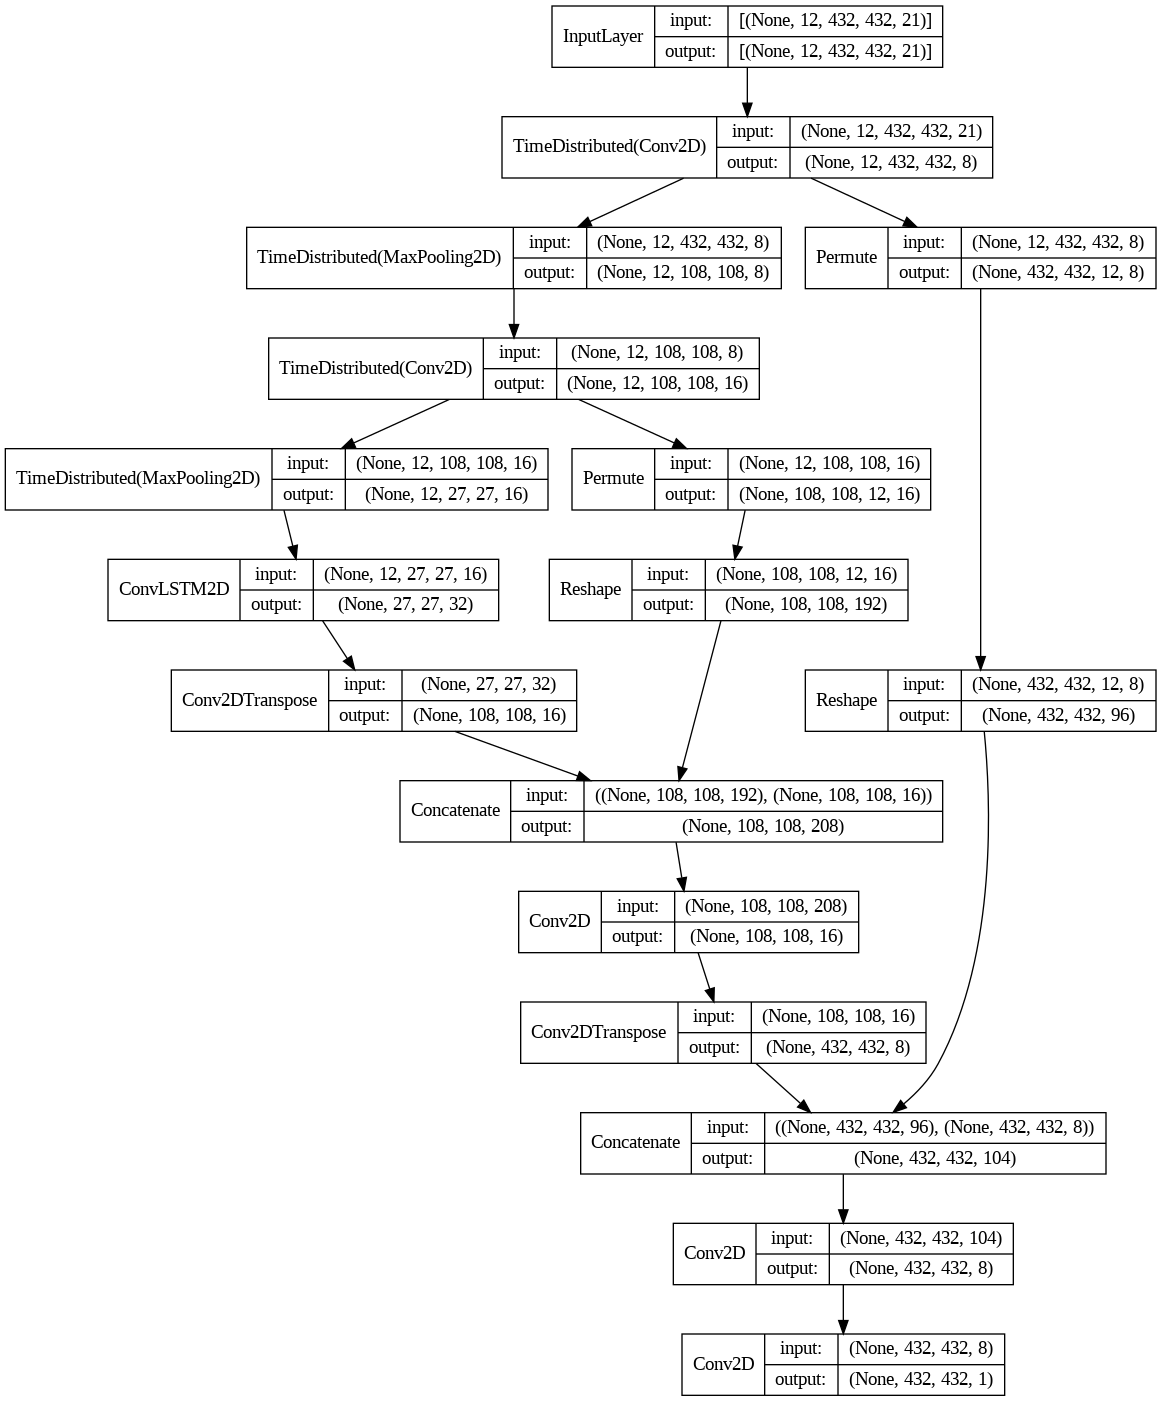

In [ ]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

## Code needed to view results

In [ ]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from math import sqrt
from typing import Union, List

@dataclass
class ModelConfig:
    input_classification_threshold: float = -1
    output_classification_threshold: float = -1
    use_lstm: bool = False
    use_active_region_mask: bool = False # whether to use Andersson et al.'s active layer mask or just the subregion mask

    @property
    def classification(self):
        return (self.input_classification_threshold > 0) or (self.output_classification_threshold > 0)

    @property
    def name(self):
        arch = 'lstm' if self.use_lstm else 'cnn'
        type_str = 'classification' if self.classification else 'regression'
        if self.input_classification_threshold > 0:
          type_str += f'_in_{str(self.input_classification_threshold).replace(".", "_")}'
        if self.output_classification_threshold > 0:
          type_str += f'_out_{str(self.output_classification_threshold).replace(".", "_")}'

        return f"{arch}_{type_str}"

def actual_and_predicted(model, seq):
  y_actual = np.array([seq[i][1] for i in range(len(seq))])
  y_hat = model.predict(seq)
  return y_actual.squeeze(), y_hat.squeeze()

def results_of(actual, predicted, classification=False):
  mse = mean_squared_error(actual, predicted)
  results = {
      'mse': mse,
      'rmse': sqrt(mse),
      'mae': mean_absolute_error(actual, predicted),
      'r2': r2_score(actual, predicted)
  }
  if classification:
      results['bin_acc'] = accuracy_score(actual, predicted)
      results['confusion'] = confusion_matrix(actual, predicted, normalize="true")
  return results

# evaluate only the results in the seas mask
# mask should be a boolean array
def flatten_and_mask(array, mask):
  # expand the mask to fit the array's dimensions in dimensions -1 and 0
  repeated_mask = np.repeat(np.expand_dims(np.repeat(mask, array.shape[-1], axis=-1), axis=0), array.shape[0], axis=0)
  assert array.shape == repeated_mask.shape
  return array.flatten()[repeated_mask.flatten().astype(bool)]

def get_results(model: Union[keras.Model, List[keras.Model]], seq, config: ModelConfig):
  models = [model] if isinstance(model, keras.Model) else model

  y_hat_list = []
  for m in models:
    # these are tuples
    y_actual, y_hat = actual_and_predicted(m, seq)
    y_hat_list.append(y_hat)
  if len(models) > 1:
    y_hat = np.mean(np.stack(y_hat_list, axis=-1), axis=-1)

  if config.input_classification_threshold > 0:
    y_actual = to_binary(y_actual, config.input_classification_threshold)
  if config.output_classification_threshold > 0:
    y_hat = to_binary(y_hat, config.output_classification_threshold)

  # to do: change (??? what)
  # the flatten_and_mask stuff should probably be in results_of rather than here
  return results_of(flatten_and_mask(y_hat, seas_mask), flatten_and_mask(y_actual, seas_mask), config.classification), y_actual, y_hat

class EnsembleConfig:
  def __init__(self, model_configs: List[ModelConfig], instances: list[int]):
    assert len(model_configs) == len(instances)
    self.model_configs = model_configs
    self.instances = instances

  @property
  def name(self):
    n = "ensemble"
    for i in range(len(self.model_configs)):
      n += f"_{self.model_configs[i].name}_instance_{self.instances[i]}"
    return n


## Code needed to save results

In [ ]:
# allow loading models to work
!pip install --upgrade tensorflow==2.14.0

In [ ]:
# Code in this cell is shared between model and view results. Make sure to keep them consistent!!!

import numpy as np
import os
import pickle
import shutil

from pathlib import Path
from tensorflow import keras
from typing import Dict, List, Union, Tuple

RESULTS_PATH = 'drive/MyDrive/Andrew Arctic ice research/Results'

class GoogleDriveContextManager:
  def __init__(self):
    self.mounted = False

  def __enter__(self):
    path = '/content/drive'
    if not os.path.exists(path):
      drive.mount('/content/drive')
      self.mounted = True

  def __exit__(self, exc_type, exc_value, exc_tb):
    # Only unmount if context manager mounted it
    if self.mounted:
      drive.flush_and_unmount()
      self.mounted = False

class Result:
  # note that history isn't a keras.callbacks.History but rather the .history of it
  def __init__(self,
               model:Union[keras.Model, List[keras.Model]],
               history: Union[Dict[str, Tuple[float, ...]], List[dict[str, tuple[float, ...]]]],
               train_y_actual: np.ndarray,
               train_y_hat: np.ndarray,
               val_y_actual: np.ndarray,
               val_y_hat: np.ndarray,
               test_y_actual: np.ndarray,
               test_y_hat: np.ndarray,
               ) -> None:
    self.model = model
    self.history = history
    self.train_y_actual = train_y_actual
    self.train_y_hat = train_y_hat
    self.val_y_actual = val_y_actual
    self.val_y_hat = val_y_hat
    self.test_y_actual = test_y_actual
    self.test_y_hat = test_y_hat

  @staticmethod
  def _to_model_filename(i: int) -> str:
    return "model.keras" if i ==0 else f"model_{i}.keras"

  # saving val_y_actual and test_y_actual is technically redundant but slightly more convenient,
  # though maybe it should be standardized as the lead time may change which points are included
  # note that this doesn't have results; those should be calculated based on what is saved here.
  def save_to(self,
              folder: os.PathLike,
              to_gdrive: bool = True,
              force: bool = False,
              ) -> None:
    if os.path.exists(folder):
      shutil.rmtree(folder)

    Path(folder).mkdir(parents=True)

    if isinstance(self.model, keras.Model):
      models = [self.model]
    else:
      models = self.model
    for i, model in enumerate(models):
      model.save(os.path.join(folder, self._to_model_filename(i)))

    with open(os.path.join(folder, 'results.pkl'), 'wb') as f:
      pickle.dump({'history': self.history,
                   'train_y_actual': self.train_y_actual,
                   'train_y_hat': self.train_y_hat,
                   'val_y_actual': self.val_y_actual,
                   'val_y_hat': self.val_y_hat,
                   'test_y_actual': self.test_y_actual,
                   'test_y_hat': self.test_y_hat,
                   },
                  f)

    if to_gdrive:
      with GoogleDriveContextManager():
        dst = os.path.join(RESULTS_PATH, folder)
        if force:
          shutil.rmtree(dst, ignore_errors=True)
        Path(dst).mkdir(parents=True)
        shutil.copytree(folder, dst, dirs_exist_ok=True)

  @classmethod
  def from_gdrive(cls, folder: os.PathLike):# -> Result:
    with GoogleDriveContextManager():
      shutil.rmtree(folder, ignore_errors=True)
      Path(folder).mkdir(parents=True)
      shutil.copytree(os.path.join(RESULTS_PATH, folder), folder, dirs_exist_ok=True)

    files = os.listdir(folder)
    model_files = [f for f in files if f.endswith(".keras")]
    n_model = len(model_files)
    models = []
    for i in range(n_model):
      model = keras.models.load_model(
        os.path.join(folder, Result._to_model_filename(i)),
        custom_objects={
          'masked_mse': masked_mse,
          'masked_bce': masked_bce,
          'wavelet_activation': wavelet_activation,
        }
      )
      models.append(model)
    # unbox if only one model
    if n_model == 1:
      models = models[0]

    with open(os.path.join(folder, 'results.pkl'), 'rb') as f:
      results = pickle.load(f)

    return cls(models, results['history'], results['train_y_actual'], results['train_y_hat'], results['val_y_actual'], results['val_y_hat'], results['test_y_actual'], results['test_y_hat'])

In [ ]:
# maybe make sure that the bottom is 0
def show_history(history, name=None):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title(f"{name} model loss" if name else 'model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

def show_metrics(results, name=None):
  if name:
    print(f"Model: {name}")
  print(f"Mean squared error: {results['mse']}")
  print(f"Root mean squared error: {results['rmse']}")
  print(f"Mean absolute error: {results['mae']}")
  print(f"R^2 score: {results['r2']}")
  if 'bin_acc' in results:
      print(f"Binary accuracy: {results['bin_acc']}")
  if 'confusion' in results:
      print("Confusion matrix:")
      print(f"{np.around(results['confusion'], 3)}")

Note: maybe create something like a new `do_full_thing()`

Also make it easier to test the whole process without having to train the entire model

  # Running code,   

In [ ]:
def to_binary(a: np.ndarray, threshold: float):
  return (a >= threshold).astype(np.float32)

def run_one(Xs, y: np.ndarray, model_config: ModelConfig, epochs: int, num_prev_months: int=12, pre_trained_dir=None):
  if model_config.classification:
    y = to_binary(y, model_config.input_classification_threshold)
  #y = get_X_with_variables(('concentration',))
  #y = (get_X_with_variables(('extent',)) > 0) # for classification; note that extent is normalized and this is a (hacky) way to denormalize it precisely

  # not sure where to put this
  # also it's not exactly the actual values since it's slightly bigger, and I'll have to do something about that
  # but I guess the point is that these can be used to generate the val_seq and test_seq (but they need the Xs)
  # _, _, _, y_val, _, y_test = train_val_test(Xs, y)

  #lead_times = (1, 3, 6)
  lead_times = (1, 2, 3, 4, 5, 6) # this should also stay the same
  # may want to do all 6 months as lead times if it doesn't make things slower
  # but keep 3 for now as testing

  train_seq, val_seq, test_seq = get_sequences(Xs, y, train_num_batches=64, num_prev_timesteps=num_prev_months, lead_times=lead_times, concat=not model_config.use_lstm)

  # maybe move the dealing with shapes into the model itself
  if pre_trained_dir:
    with GoogleDriveContextManager():
      print(f"Loading pretrained model from {pre_trained_dir}")
      experiment = Result.from_gdrive(pre_trained_dir)
      model = experiment.model
      assert isinstance(model, keras.Model)
      history = experiment.history
  else:
    if not model_config.use_lstm:
      model = make_model(input_shape=Xs[0].shape[1:-1] + (num_prev_months * Xs[0].shape[-1],), use_lstm=False, umap=False, num_output_months=len(lead_times), classification=model_config.classification)
    else:
      model = make_model(input_shape=(num_prev_months,) + Xs[0].shape[1:], use_lstm=True, umap=False, num_output_months=len(lead_times), classification=model_config.classification)

    history = fit(model, train_seq, val_seq, epochs=epochs).history
  return history, model, train_seq, val_seq, test_seq

# configs is a list of (model_config, [result_model_config])
def run_all(configs, Xs, y: np.ndarray, snapshot: str, epochs=36, num_prev_months: int=12, force=False):
  saved_models = {}
  for model_config, result_model_configs in configs:
    print(f"Running model {model_config.name}")
    history, model, train_seq, val_seq, test_seq = run_one(Xs, y, model_config, epochs=epochs, num_prev_months=num_prev_months)
    saved_models[model_config.name] = (model, history)
    for result_model_config in result_model_configs:
      experiment_name = model_config.name
      if result_model_config != model_config:
        experiment_name += f"__{result_model_config.name}"

      train_results, train_y_actual, train_y_hat = None, None, None # get_results(model, train_seq, config=result_model_config)
      val_results, val_y_actual, val_y_hat = get_results(model, val_seq, config=result_model_config)
      test_results, test_y_actual, test_y_hat = get_results(model, test_seq, config=result_model_config)

      model_results = Result(model, history, train_y_actual, train_y_hat, val_y_actual, val_y_hat, test_y_actual, test_y_hat)
      model_results.save_to(f"{snapshot}/{experiment_name}", force=force)

      print(f"Showing results for {experiment_name}")
      show_metrics(val_results, name=f"{experiment_name}")
      show_history(history, name=f"{experiment_name}")
  return saved_models

# configs is a list of EnssembleConfig
def run_ensemble(ensemble_configs: List[EnsembleConfig], Xs, y: np.ndarray, snapshot: str, epochs=36, num_prev_months: int=12, force=False,  pre_trained_dirs=None):
  pre_trained_idx = 0
  for ensemble_config in ensemble_configs:
    print(f"Running ensemble for {ensemble_config.name}")
    ensemble_models = []
    ensemble_histories = []
    for model_config, instances in zip(ensemble_config.model_configs, ensemble_config.instances):
      for instance in range(instances):
        experiment_name = f"{model_config.name}_instance_{instance}"
        print(f"Running experiment {experiment_name}")
        history, model, train_seq, val_seq, test_seq = run_one(Xs, y, model_config, epochs=epochs, num_prev_months=num_prev_months,
                                                               pre_trained_dir=pre_trained_dirs[pre_trained_idx] if pre_trained_dirs else None)
        pre_trained_idx += 1
        ensemble_models.append(model)
        ensemble_histories.append(history)
        val_results, val_y_actual, val_y_hat = get_results(model, val_seq, config=model_config)
        print(f"Showing validation results for {experiment_name}")
        show_metrics(val_results, name=f"{experiment_name}")
        show_history(history, name=f"{experiment_name}")

    val_results, val_y_actual, val_y_hat = get_results(ensemble_models, val_seq, config=ensemble_config.model_configs[0])
    test_results, test_y_actual, test_y_hat = get_results(ensemble_models, test_seq, config=ensemble_config.model_configs[0])
    ensemble_model_results = Result(ensemble_models, ensemble_histories, None, None, val_y_actual, val_y_hat, test_y_actual, test_y_hat)
    ensemble_model_results.save_to(f"{snapshot}/{ensemble_config.name}", force=force)

    print(f"Showing validation results for {ensemble_config.name}")
    show_metrics(val_results, name=f"{ensemble_config.name}")

CNN_REGRESSION_CONFIG = ModelConfig(
    use_lstm=False
)
CNN_REGRESSION_TO_CLASSIFICATION_CONFIG = ModelConfig(
    input_classification_threshold=0.15,
    output_classification_threshold=0.15,
    use_lstm=False
)
CNN_CLASSIFICATION_CONFIG = ModelConfig(
    input_classification_threshold=0.15,
    output_classification_threshold=0.5,
    use_lstm=False
)
LSTM_REGRESSION_CONFIG = ModelConfig(
    use_lstm=True
)
LSTM_REGRESSION_TO_CLASSIFICATION_CONFIG = ModelConfig(
    input_classification_threshold=0.15,
    output_classification_threshold=0.15,
    use_lstm=True
)
LSTM_CLASSIFICATION_CONFIG = ModelConfig(
    input_classification_threshold=0.15,
    output_classification_threshold=0.5,
    use_lstm=True
)

CONC_VARRIABLES = ('concentration',)
SHORT_VARIABLES = ('concentration', 'sst', 'tp', 'slhf', 'sp')
CHEN_VARRIABLES = ('concentration', 'sst', 'tp', 'slhf', 'sshf', 'sp', 'q_500hPa')
ANDERSON_VARRIABLES = ('concentration', 'sst', 't2m', 't_500hPa',
  'u10', 'v10', 'z_500hPa', 'z_250hPa', 'u_10hPa', 'ssrd', 'ssr',
  'msl', 'land', 'cos_month', 'sin_month')
FULL_VARRIABLES = ('concentration', 'sst', 't2m', 't_500hPa',
  'tp', 'slhf', 'sshf','u10', 'v10', 'z_500hPa', 'z_250hPa',
  'u_10hPa', 'ssrd', 'ssr', 'sp', 'msl', 'q_500hPa',
  'land', 'cos_month', 'sin_month')

ALL_ARCH_CONFIGS = [
    (CNN_REGRESSION_CONFIG, [CNN_REGRESSION_CONFIG, CNN_REGRESSION_TO_CLASSIFICATION_CONFIG]),
    (CNN_CLASSIFICATION_CONFIG, [CNN_CLASSIFICATION_CONFIG]),
    (LSTM_REGRESSION_CONFIG, [LSTM_REGRESSION_CONFIG, LSTM_REGRESSION_TO_CLASSIFICATION_CONFIG]),
    (LSTM_CLASSIFICATION_CONFIG, [LSTM_CLASSIFICATION_CONFIG]),
]

CLASSIFICATION_ARCH_CONFIGS = [
    (CNN_CLASSIFICATION_CONFIG, [CNN_CLASSIFICATION_CONFIG]),
    (LSTM_CLASSIFICATION_CONFIG, [LSTM_CLASSIFICATION_CONFIG]),
]

In [ ]:
variables = CONC_VARRIABLES
ensemble_configs = [EnsembleConfig([LSTM_CLASSIFICATION_CONFIG], [3])]

# Wavelet
# snapshot = f"conc_20230904_ensemble"
# run_ensemble(ensemble_configs=ensemble_configs, Xs=(get_X_with_variables(variables),), y=y, snapshot=snapshot, epochs=36, num_prev_months=12, force=True)

# for wavelet in list(WAVELETS.keys()):
#   snapshot = f"conc_{wavelet}_20230904_ensemble"
#   print(f"Starting experiment {snapshot} with variables {variables}")
#   input_x = add_wavelet_data(get_X_with_variables(variables), variables, [WAVELETS[wavelet]])
#   run_ensemble(ensemble_configs=ensemble_configs, Xs=(input_x,), y=y, snapshot=snapshot, epochs=36, num_prev_months=12, force=False)

# Umap
snapshot = f"conc_umap_20230904_ensemble"
all_x = get_X_with_variables(variables)
train_x, _, _, _, _, _ = train_val_test((all_x,), y)
train_x = train_x[0] # unbox ndarry from tuple
all_x_umap = add_umap_data(train_x=train_x, transform_x=all_x, cache=True)
run_ensemble(ensemble_configs=ensemble_configs, Xs=(all_x_umap,), y=y, snapshot=snapshot, epochs=36, num_prev_months=12, force=True)


2023-09-16 19:36:54.948550 training UMAP model n_neighbors=2 min_dist=0.0 metric=euclidean


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


KeyboardInterrupt: ignored

In [ ]:
# configs = [(LSTM_CLASSIFICATION_CONFIG, [LSTM_CLASSIFICATION_CONFIG]),]

# for suffix in ["", "_1", "_2"]:
#   for wavelet in WAVELETS.keys():
#     snapshot = f"conc_{wavelet}_20230904{suffix}"
#     variables = CONC_VARRIABLES
#     print(f"Starting experiment {snapshot} with variables {variables}")
#     input_x = add_wavelet_data(get_X_with_variables(variables), variables, [WAVELETS[wavelet]])
#     saved_models = run_all(configs=configs, Xs=(input_x,), y=y, snapshot=snapshot, epochs=36, num_prev_months=12, force=False)

# Post training essemble

In [ ]:
# model_config = LSTM_CLASSIFICATION_CONFIG
# ensemble_configs = [EnsembleConfig([model_config], [3])]

# for name, variables in [("conc", CONC_VARRIABLES), ("short", SHORT_VARIABLES), ("chen", CHEN_VARRIABLES), ("anderson", ANDERSON_VARRIABLES), ("full", FULL_VARRIABLES)]:
#   snapshot = f"{name}_20230904_ensemble"
#   run_ensemble(ensemble_configs=ensemble_configs, Xs=(get_X_with_variables(variables),), y=y, snapshot=snapshot, epochs=36, num_prev_months=12, force=False,
#                pre_trained_dirs=[f"{name}_20230904{suffix}/{model_config.name}" for suffix in ("", "_1", "_2")])


variables = CONC_VARRIABLES
name = "conc_arch"#"conc_24m"
for model_arch, result_archs in CLASSIFICATION_ARCH_CONFIGS:
  model_config = model_arch
  for result_arch in result_archs:
    ensemble_configs = [EnsembleConfig([model_config], [3])]
    snapshot = f"{name}_20230904_ensemble"
    run_ensemble(ensemble_configs=ensemble_configs, Xs=(get_X_with_variables(variables),), y=y, snapshot=snapshot, epochs=36, num_prev_months=24, force=False,
                pre_trained_dirs=[f"{name}_20230904{suffix}/{model_config.name}" for suffix in ("", "_1", "_2")])

Running ensemble for ensemble_cnn_classification_in_0_15_out_0_5_instance_3
Running experiment cnn_classification_in_0_15_out_0_5_instance_0
Loading pretrained model from conc_arch_20230904/cnn_classification_in_0_15_out_0_5


UnimplementedError: ignored

In [ ]:
%ls "drive/MyDrive/Andrew Arctic ice research/Results/conc_20230904"

lstm_classification_in_0_15_out_0_5/


In [ ]:
%ls "drive/MyDrive/Andrew Arctic ice research/Results/CSVs"

 anderson_20230904_1.csv
 anderson_20230904_2.csv
 anderson_20230904.csv
 anderson_20230904_ensemble.csv
 chen_20230904_1.csv
 chen_20230904_2.csv
 chen_20230904.csv
 chen_20230904_ensemble.csv
'cnn (1).gsheet'
 cnn.csv
 cnn.gsheet
 combined_20230904.csv
 combined_24m_mean_20230904.csv
 combined_24m_median_20230904.csv
 combined_mean_20230904.csv
 combined_mean_20230904.gsheet
 combined_median_20230904.csv
'combined_median_20230904 Paper version 1.gsheet'
 combined_variables_20230904.csv
'combined_variables_20230916 Paper version 2.gsheet'
 combined_wavelet_20230904.csv
 combined_wavelet_20230904.gsheet
 conc_20230904_1.csv
 conc_20230904_2.csv
 conc_20230904.csv
 conc_20230904_ensemble.csv
 conc_24m_20230904_1.csv
 conc_24m_20230904_2.csv
 conc_24m_20230904.csv
 conc_24m_20230904_ensemble.csv
 conc_arch_20230904_1.csv
 conc_arch_20230904_2.csv
 conc_arch_20230904.csv
 conc_db1_20230904_ensemble.csv
 conc_db2_20230904_ensemble.csv
 conc_db3_20230904_ensemble.csv
 conc_db4_20230904_ense